In [ ]:
import argparse
import logging
import os
import sys
import ultralytics
import cv2
import torch
import yt_dlp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ultralytics.utils.plotting import colors

In [2]:
# Change directory
os.chdir('/Users/arielmalowany/Desktop/Learning/COUNT-GEN/COUNT-GEN-REPLICABILITY/mivolo/MiVOLO-main')

In [3]:
# Scripts
from mivolo.data.data_reader import InputType, get_all_files, get_input_type
from mivolo.predictor import Predictor
from timm.utils import setup_default_logging

_logger = logging.getLogger("inference")

/opt/anaconda3/envs/count-gen-demo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Helper function
def get_parser():
    parser = argparse.ArgumentParser(description="PyTorch MiVOLO Inference")
    parser.add_argument("--input", type=str, default=None, required=True, help="image file or folder with images")
    parser.add_argument("--output", type=str, default=None, required=True, help="folder for output results")
    parser.add_argument("--detector-weights", type=str, default=None, required=True, help="Detector weights (YOLOv8).")
    parser.add_argument("--checkpoint", default="", type=str, required=True, help="path to mivolo checkpoint")

    parser.add_argument(
        "--with-persons", action="store_true", default=False, help="If set model will run with persons, if available"
    )
    parser.add_argument(
        "--disable-faces", action="store_true", default=False, help="If set model will use only persons if available"
    )

    parser.add_argument("--draw", action="store_true", default=False, help="If set, resulted images will be drawn")
    parser.add_argument("--device", default="cuda", type=str, help="Device (accelerator) to use.")

    return parser

In [ ]:
# Load the predictor
input = "/Users/arielmalowany/Desktop/Learning/COUNT-GEN/COUNT-GEN-REPLICABILITY/data/custom/familia.jpg" 
detector_weights = "./models/yolov8x_person_face.pt"
checkpoint =  "./models/model_imdb_cross_person_4.22_99.46.pth.tar"
device = "cpu"

parser = get_parser()
args = parser.parse_args(
    [
        "--input",f"""{input}""", 
        "--detector-weights", f"""{detector_weights}""", 
        "--checkpoint", f"""{checkpoint}""", 
        "--device", f"""{device}""",
        "--output", 'output',
        "--with-persons",
        "--draw"
        
    ]
)

predictor = Predictor(args, verbose=True)

Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


In [26]:
# Inference

img = cv2.imread(input) 
detected_objects, out_im = predictor.recognize(img)
bname = os.path.splitext(os.path.basename(input))[0]
filename = os.path.join(args.output, f"out_{bname}.jpg")
cv2.imwrite(filename, out_im)
_logger.info(f"Saved result to {filename}")



0: 640x480 6 persons, 6 faces, 286.5ms
Speed: 2.7ms preprocess, 286.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


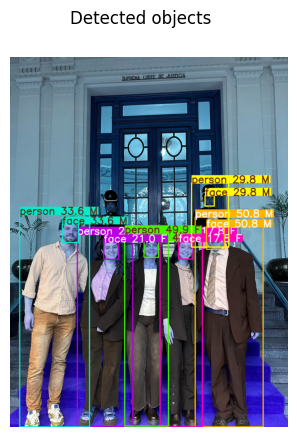

In [38]:
# Print output 

%matplotlib inline
plt.imshow(out_im)
plt.axis('off')
plt.suptitle('Detected objects')
plt.show()

In [167]:
# Create dataframe

pred_boxes = detected_objects.yolo_results.boxes
xy_coords = pred_boxes.xyxy
person_id = 0
age_gender_pd = pd.DataFrame(columns = ["person_id", "age", "gender_string", "gender_score", "gender_prob"])
for face_ind, person_ind in detected_objects.face_to_person_map.items():
  y1 = int(torch.round(xy_coords[face_ind][1]).item())
  y2 = int(torch.round(xy_coords[face_ind][3]).item())
  x1 = int(torch.round(xy_coords[face_ind][0]).item())
  x2 = int(torch.round(xy_coords[face_ind][2]).item())
  crop_img = img[y1:y2, x1:x2]
  file_name = f"{bname}_person_{person_id}_face.jpg"
  save_path = os.path.join('output', file_name)
  cv2.imwrite(save_path, crop_img)
  age = detected_objects.ages[face_ind]
  gender_string = detected_objects.genders[face_ind]
  gender_score = detected_objects.gender_scores[face_ind]
  if gender_string == "male":
    gender_prob = 1 - gender_score
  elif gender_string == "female":
    gender_prob = gender_score
  row = pd.DataFrame([[person_id, age, gender_string, gender_score, gender_prob]], columns = ["person_id", "age", "gender_string", "gender_score", "gender_prob"])
  age_gender_pd = pd.concat([age_gender_pd, row])
  person_id += 1
  

/var/folders/5j/bzx1pm2n5fg14pqsndlhvb700000gn/T/ipykernel_18974/3070416658.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  age_gender_pd = pd.concat([age_gender_pd, row])


In [168]:
age_gender_pd

,person_id,age,gender_string,gender_score,gender_prob
0,0,33.57,male,0.997212,0.002788
0,1,49.87,female,0.997429,0.997429
0,2,17.83,female,0.997165,0.997165
0,3,50.84,male,0.997241,0.002759
0,4,20.99,female,0.995797,0.995797
0,5,29.77,male,0.997165,0.002835
